<a href="https://colab.research.google.com/github/salmanromeo/1D_Pitching_Moment/blob/main/1D_Pitching_Moment_NCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install seaborn

In [ ]:
pip install ncps

In [ ]:
pip install torch

In [ ]:
pip install pytorch_lightning

In [113]:
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as data

data_x.shape:  (1, 300, 11)
data_y.shape:  (1, 300, 1)


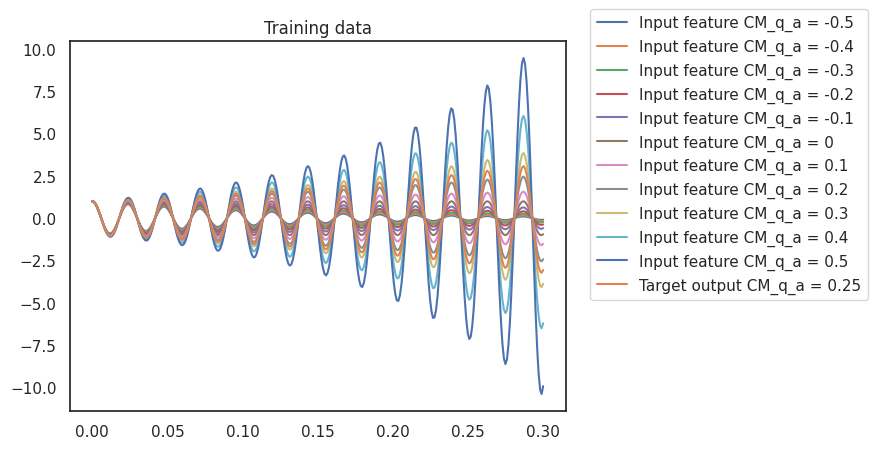

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Main
A       = 1
ro      = 1.20
v       = 858
s       = 0.00385
d       = 0.07
CM_q_a  = 0.25
CM_a    = -0.09
I       = 1.55e-4
phi     = 0
N = 300 # Length of the time-series

# Input feature is a sine and a cosine wave
def oscillator(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t):
    w = np.sqrt(-((ro*v**2*s*d*CM_a)/(2*I)))    # w is omega
    cos = np.cos(w*t + phi)
    e = (ro*v*s*d**2)*(CM_q_a)/(8*I)            # e is epsilon
    exp = np.exp(e*t)
    y  = A*exp*cos                              # y is alpha
    return y

# get the analytical solution over the full domain
t = np.linspace(0,0.3,N)
y = oscillator(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t)

data_x = np.stack(
    [oscillator(A, ro, v, s, d, -0.5, CM_a, I, phi, t), 
     oscillator(A, ro, v, s, d, -0.4, CM_a, I, phi, t),
     oscillator(A, ro, v, s, d, -0.3, CM_a, I, phi, t),
     oscillator(A, ro, v, s, d, -0.2, CM_a, I, phi, t),
     oscillator(A, ro, v, s, d, -0.1, CM_a, I, phi, t),
     oscillator(A, ro, v, s, d, 0, CM_a, I, phi, t),
     oscillator(A, ro, v, s, d, 0.1, CM_a, I, phi, t),
     oscillator(A, ro, v, s, d, 0.2, CM_a, I, phi, t),
     oscillator(A, ro, v, s, d, 0.3, CM_a, I, phi, t),
     oscillator(A, ro, v, s, d, 0.4, CM_a, I, phi, t),
     oscillator(A, ro, v, s, d, 0.5, CM_a, I, phi, t)
     ], axis=1)

# t_data = t[0:150:1]
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = y.reshape([1, N, 1]).astype(np.float32)
print("data_x.shape: ", str(data_x.shape))
print("data_y.shape: ", str(data_y.shape))
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4)

# Let's visualize the training data
# sns.set()
plt.figure()
plt.plot(t, data_x[0, :, 0], label="Input feature CM_q_a = -0.5")
plt.plot(t, data_x[0, :, 1], label="Input feature CM_q_a = -0.4")
plt.plot(t, data_x[0, :, 2], label="Input feature CM_q_a = -0.3")
plt.plot(t, data_x[0, :, 3], label="Input feature CM_q_a = -0.2")
plt.plot(t, data_x[0, :, 4], label="Input feature CM_q_a = -0.1")
plt.plot(t, data_x[0, :, 5], label="Input feature CM_q_a = 0")
plt.plot(t, data_x[0, :, 6], label="Input feature CM_q_a = 0.1")
plt.plot(t, data_x[0, :, 7], label="Input feature CM_q_a = 0.2")
plt.plot(t, data_x[0, :, 8], label="Input feature CM_q_a = 0.3")
plt.plot(t, data_x[0, :, 9], label="Input feature CM_q_a = 0.4")
plt.plot(t, data_x[0, :, 10], label="Input feature CM_q_a = 0.5")
plt.plot(t, data_y[0, :, 0], label="Target output CM_q_a = 0.25")
plt.title("Training data")
plt.legend(loc=(1.05,0.3))
plt.show()

In [116]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [117]:
wiring = AutoNCP(22, 1)  # 16 units, 1 motor neuron

ltc_model = LTC(11, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

alloc!


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


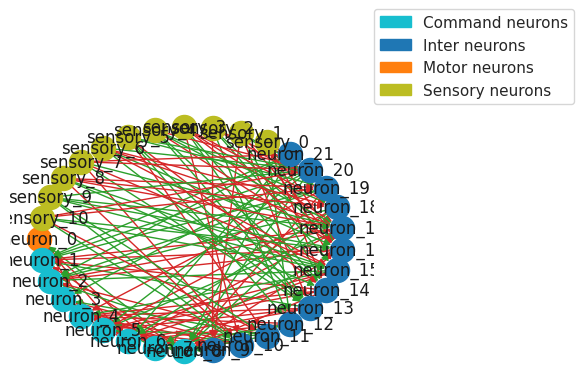

In [118]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc=(1.05,0.3), bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

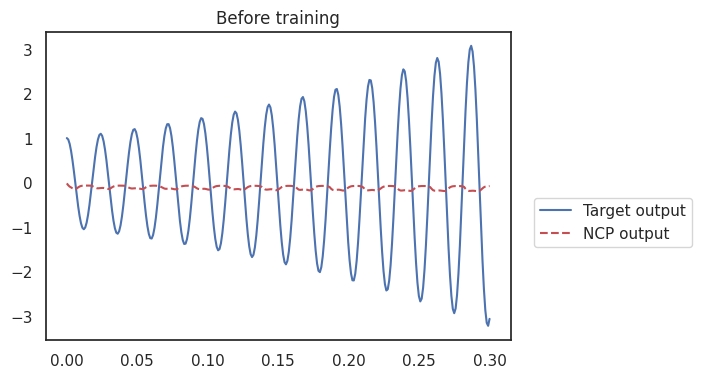

In [119]:
# Let's visualize how LTC initialy performs before the training
sns.set_style("white")
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(t, data_y[0, :, 0], 'b', label="Target output")
plt.plot(t, prediction[0, :, 0], '--r', label="NCP output")
plt.title("Before training")
plt.legend(loc=(1.05,0.3))
plt.show()

In [120]:
# Train the model for 400 epochs (= training steps)
trainer.fit(learn, dataloader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | LTC  | 3.7 K 
-------------------------------
3.0 K     Trainable params
726       Non-trainable params
3.7 K     Total params
0.015     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


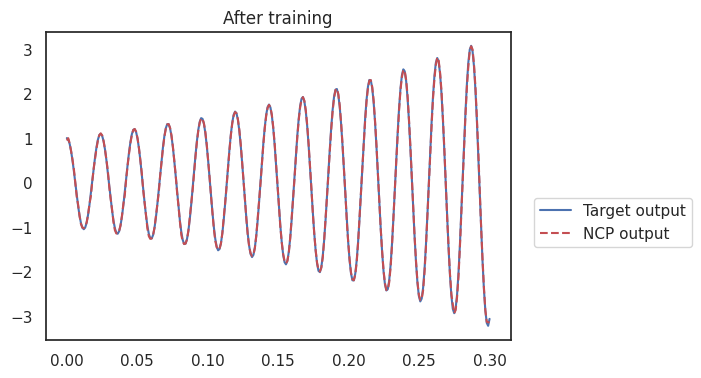

In [121]:
# How does the trained model now fit to the sinusoidal function?
sns.set_style("white")
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(t, data_y[0, :, 0], 'b', label="Target output")
plt.plot(t, prediction[0, :, 0], '--r', label="NCP output")
plt.title("After training")
plt.legend(loc=(1.05,0.3))
plt.show()